# Backpropagation Lab





In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
from tabulate import tabulate
from IPython.display import HTML, display
from random import seed
from random import randint

## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with mean of 0 and a variance of 1.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- Option to include a momentum term

You may use your own random train/test split or use the scikit-learn version if you want.

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [3]:
class MLP(BaseEstimator,ClassifierMixin):
    is_binary = True
    layer2_weights = []
    layer1_weights = []
    prevDeltaW = []
    numOutputs = 0
    classificationAcc_perEpoch = []
    MSEperEpoch = []
    MSEperEpoch_validation = []
    ranEpochs = 0
    def __init__(self,lr=.1, momentum=0, validationSize = 0, shuffle=True, hidden_layer_widths=None, numEpochs=10, sensitivity=10):
        """ Initialize class with chosen hyperparameters.

        Args:
            lr (float): A learning rate / step size.
            shuffle(boolean): Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
            momentum(float): The momentum coefficent 
        Optional Args (Args we think will make your life easier):
            hidden_layer_widths (list(int)): A list of integers which defines the width of each hidden layer if hidden layer is none do twice as many hidden nodes as input nodes.
        Example:
            mlp = MLP(lr=.2,momentum=.5,shuffle=False,hidden_layer_widths = [3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.layer1_weights = []
        self.layer2_weights = []
        self.prevDeltaW = []
        self.is_binary = True
        self.validationSize = validationSize
        self.numEpochs = numEpochs
        self.sensitivity = sensitivity
    
    def set_numOutput(self, setTo):
        self.numOutputs = setTo
    
    def set_numEpochs(self, setTo):
        self.numEpochs = setTo
    
    def forward_pass(self, x):
        # -------------- first row ---------------
        listOfOuts = []
        temp2 = []
        for item in x:
            temp2.append(item)
        temp2.append(1) # for the bias
        listOfOuts.append(temp2)
        #print('listofins: ', listOfOuts)
        listOfNets = []
        temp2 = []
        for inc in range(self.hidden_layer_widths):
            tempWeights = []
            for weight in self.layer1_weights:
                tempWeights.append(weight[inc])
            #print('tempW: ', tempWeights)
            net = np.dot(listOfOuts[0], tempWeights) # use 0 for first row
            #print('net: ', net)
            temp2.append(net) # this is used to add another dimention to listOfNets to separate it based on 'layer'
        listOfNets.append(temp2)
        #print('listofnets: ', listOfNets)

        # --------------- second row ---------------
        temp2 = []
        for inc in range(self.hidden_layer_widths):
            temp = 1 / (1 + np.exp(-1 * listOfNets[0][inc]))
            temp2.append(temp)
        temp2.append(1) # for the bias
        listOfOuts.append(temp2)
        #print('listofouts: ', listOfOuts)

        temp2 = []
        for inc in range(self.numOutputs):
            tempWeights = []
            for weight in self.layer2_weights:
                tempWeights.append(weight[inc])
            net = np.dot(listOfOuts[1], tempWeights)
            temp2.append(net)
        listOfNets.append(temp2)

        # --------------- output row ---------------
        temp2 = []
        for inc in range(self.numOutputs):
            temp = 1 / (1 + np.exp(-1 * listOfNets[1][inc]))
            temp2.append(temp)
        listOfOuts.append(temp2)
        #print('N: ', listOfNets)
        #print('O: ', listOfOuts)
        return listOfNets, listOfOuts

    def backward_pass(self, listOfNets, listOfOuts, y):
        listOfSig = []
        deltaW = []

        # --------------- 2nd layer ------------------
        temp2 = []
        #print('loO: ', listOfOuts)
        for node in range(len(listOfOuts[2])):
            temp = (y[node] - listOfOuts[2][node]) * (listOfOuts[2][node] * (1 - listOfOuts[2][node]))
            temp2.append(temp)
        listOfSig.append(temp2)

        temp2 = []
        prevPos = 0
        for node in range(len(listOfOuts[1])):
            for node2 in range(len(listOfSig[0])):
                #print('lr: ', self.lr)
                #print('loO: ', listOfOuts[1][node])
                #print('loS: ', listOfSig[node2])
                if len(self.prevDeltaW) != 0:
                    temp = self.lr * listOfOuts[1][node] * listOfSig[0][node2] + (self.momentum * self.prevDeltaW[0][prevPos])
                else:
                    temp = self.lr * listOfOuts[1][node] * listOfSig[0][node2]
                temp2.append(temp)
                prevPos += 1  
        deltaW.append(temp2) # this goes w31, w32, w41, w42, etc. | temp2 used to add another dimention for organization
        #print('dW: ', deltaW)

        # ---------------- 1st layer -----------------
        temp2 = []
        #print(self.layer2_weights)
        #print(listOfSig)
        
        # --------- FIXME BELOW NEEDS FIXED ----------
        for node in range(len(self.layer2_weights)-1):
            # temp = ((sig1 * w31) + (sig2 * w32)) * (o3 * (1 - o3))
            sum = 0
            for sig in range(len(listOfSig[0])):
                sum += listOfSig[0][sig] * self.layer2_weights[node][sig]
            temp = sum * (listOfOuts[1][node] * (1 - listOfOuts[1][node]))
            temp2.append(temp)
        listOfSig.append(temp2)
        # --------------------------------------------
        #print('SIG: ', listOfSig)

        temp2 = []
        prevPos = 0
        for node in range(len(listOfOuts[0])):
            for node2 in range(len(listOfSig[1])):
                if len(self.prevDeltaW) != 0:
                    temp = self.lr * listOfOuts[0][node] * listOfSig[1][node2] + (self.momentum * self.prevDeltaW[1][prevPos])
                else:
                    temp = self.lr * listOfOuts[0][node] * listOfSig[1][node2]
                temp2.append(temp)
                prevPos += 1
                
        deltaW.append(temp2)
        #print('loO: ', listOfOuts)
        #print('loS: ', listOfSig)
        #print('dW: ', deltaW)
        return deltaW
            
    def oneHotEncode(self, input):
        # have default array
        default = []
        for i in range(self.numOutputs):
            default.append(0)

        to_return = []
        #print('in: ', input)
        for item in input:
            temp = []
            temp = default.copy()
            #print('tmp: ', temp)
            temp[int(item)] = 1
            to_return.append(temp)
        #print('ret: ', to_return)
        return to_return

    def fit_inner(self, X, y, y_to_use):
        
                for inc in range(len(X)):
                    listOfNets, listOfOuts = self.forward_pass(X[inc])
                    #print('nets: ', listOfNets)
                    #print('outs: ', listOfOuts)
                    deltaW = self.backward_pass(listOfNets, listOfOuts, y_to_use[inc]) # delW[0] = layer2, delW[1] = layer1
                    # print('dW: ', deltaW)
                    self.prevDeltaW = deltaW
                    #print('PRE - l1: ', self.layer1_weights)
                    #print('PRE - l2: ', self.layer2_weights)
                    # time to sum the weights
                    # layer2
                    weight_indx = 0
                    #print('dW: ', deltaW)
                    #print('lenL2: ', len(self.layer2_weights))
                    #print('L2: ', self.layer2_weights)
                    for node in range(len(self.layer2_weights)):
                        
                        for weight in range(len(self.layer2_weights[node])):
                            #print('windx: ', weight_indx)
                            self.layer2_weights[node][weight] += deltaW[0][weight_indx]
                            weight_indx += 1
                            #print('update')

                    # layer1
                    weight_indx = 0
                    for node in range(len(self.layer1_weights)):
                        for weight in range(len(self.layer1_weights[node])):
                            self.layer1_weights[node][weight] += deltaW[1][weight_indx]
                            weight_indx += 1
                    
                    #print('dW: ', deltaW)
                    #print('POST - l1: ', self.layer1_weights)
                    #print('POST - l2: ', self.layer2_weights)
                    #print('---------------------------------------------')
                    #if inc == 3: break
                
    def create_random_validation_split(self, X, y):
        # calculate percentage to get 
        validationPercent = self.validationSize / 100
        # this should return a value of how many samples to take from train set for validation set
        validationSetSize = int(validationPercent * len(X))

        X_return = []
        y_return = []
        seed(10)
        for i in range(validationSetSize):
            randomPos = randint(0, len(X)-1)
            X_return.append(X[randomPos])
            y_return.append(y[randomPos])
        
        return X_return, y_return

    def fit(self, X, y, initial_weights=None):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Optional Args (Args we think will make your life easier):
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.classificationAcc_perEpoch = []
        self.MSEperEpoch = []
        self.MSEperEpoch_validation = []
        self.weights = self.initialize_weights(X) if not initial_weights else initial_weights
        #print('X: ', X)
        #print('y: ', y)
        #print('---------------------------------')
        y_to_use = []
        # have some way to determine number of classes in data, make vector of 0's that is length of num classes. Put 1 in class value
        if self.numOutputs > 1:
            y_to_use = self.oneHotEncode(y)
            # need to one-hot the target y's
        else:
            for item in y:
                y_to_use.append([item])
        useValidation = False
        if self.validationSize != 0:
            useValidation = True

        if useValidation == False:
            for i in range(self.numEpochs):
                self.fit_inner(X, y, y_to_use)

                missClass = self.score(X, y, False)
                self.classificationAcc_perEpoch.append(missClass)

                if self.shuffle:
                    self._shuffle_data(X, y)
        else:
            validationX, validationY = self.create_random_validation_split(X, y)
            keepGoing = True
            triggerCount = 0
            while(keepGoing):
                self.ranEpochs += 1
                self.fit_inner(X, y, y_to_use)

                missClass = self.score(X, y, False)
                self.classificationAcc_perEpoch.append(missClass)

                self.score(validationX, validationY, True)
                if len(self.MSEperEpoch_validation) != 0 and self.ranEpochs > 10:
                    if np.abs(self.MSEperEpoch_validation[len(self.MSEperEpoch_validation)-1] - self.MSEperEpoch_validation[len(self.MSEperEpoch_validation)-2]) < 0.00000000000000001:
                        triggerCount += 1
                    else:
                        triggerCount = 0
                if triggerCount > self.sensitivity:
                    keepGoing = False
                if self.shuffle:
                    self._shuffle_data(X, y)
                    self._shuffle_data(validationX, validationY)
        return self

    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        # forward pass (which should give confidence scores for outputs, take argmax to return class)
        toReturn = []
        for x in X:
            listOfNets, listOfOuts = self.forward_pass(x)
            outputs = np.array(listOfOuts[2])
            aMax = np.argmax(outputs)
            toReturn.append(aMax)
        #print('list: ', listOfOuts[2])
        #print('net: ', listOfNets)
        
        #print(outputs)
        
        #print(listOfOuts[2][aMax])
        return toReturn

    def initialize_weights(self, X):
        """ Initialize weights for perceptron. Don't forget the bias!

        Returns:

        """
        numHiddenLayers = 0
        if self.hidden_layer_widths != None:
            numHiddenLayers = self.hidden_layer_widths
        else:
            numHiddenLayers = 2 * len(X[0])
            self.hidden_layer_widths = numHiddenLayers
        print('lw: ', self.hidden_layer_widths)
        layer2_weights = []
        layer1_weights = []

        for d1 in range(numHiddenLayers + 1):
            temp = []
            for d2 in range(self.numOutputs):
                temp.append(0)
            layer2_weights.append(temp)
        
        for d1 in range(len(X[0]) + 1):
            temp = []
            for d2 in range(numHiddenLayers):
                temp.append(0)
            layer1_weights.append(temp)


        #print('layer1: ', layer1_weights)
        #print('layer2: ', layer2_weights)
        self.layer1_weights = layer1_weights
        self.layer2_weights = layer2_weights
        pass # WILL NEED TO RETURN THE WEIGHTS

    def score(self, X, y, validation):
        """ Return accuracy of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets

        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        mean_accuracy = 0
        SSE = 0
        result = self.predict(X)
        for idx in range(len(result)):
            #print('x[idx]: ', X[idx])
            SSE += (result[idx] - y[idx])**2
            #print('result: {x} | y[idx]: {y}'.format(x=result, y=y[idx]))
            if (result[idx] == y[idx]):
                mean_accuracy += 1
        mean_accuracy /= len(result)
        MSE = SSE / len(X)
        if validation == False:
            self.MSEperEpoch.append(MSE)
        else:
            self.MSEperEpoch_validation.append(MSE)


        return mean_accuracy

    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
             shuffling X and y exactly the same way, independently.
        """
        tempY = []
        for item in y:
            tempY.append([item])

        Z = np.concatenate((X, tempY), axis=1)
        np.random.shuffle(Z)
        
        for i in range(len(tempY[0])-1):
            tempY[i][0] = Z[i][3]
        for i in range(len(X)-1):
            for j in range(len(X[0])-1):
                X[i][j] = Z[i][j]
        
        for item in range(len(tempY)):
            #print(item)
            y[item] = tempY[item][0]
        pass

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.layer1_weights, self.layer2_weights # WILL NEED TO RETURN self.weights


## 1.1 

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_0.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_2outs.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

---------------------------------------------

In [4]:
# Load debug data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff --output load_data.arff
debug_data = arff.loadarff('load_data.arff')
data_df = pd.DataFrame(debug_data[0])

debug_np_data = data_df.to_numpy()
debug_np_data = debug_np_data.astype(float)
debug_np_data = debug_np_data.tolist()
#print(debug_np_data)

X = []
y = []
for data in debug_np_data:
    X.append(data[0:len(data)-1])
    y.append(data[len(data)-1])
#print("X: ", X)
#print("y: ", y)
 
# Train on debug data
binaryMLP = MLP(lr=0.1, momentum=0.5, shuffle=False, hidden_layer_widths=4)
binaryMLP.set_numOutput(2)
binaryMLP.fit(X, y)


#print(binaryMLP.get_weights())

#print(binaryMLP.score(X,y))
# Print weights
print(binaryMLP.get_weights())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   197  100   197    0     0     29      0  0:00:06  0:00:06 --:--:--    56
lw:  4
([[-0.00018149431827609483, -0.00018149431827609483, -0.00018149431827609483, -0.00018149431827609483], [0.0015746849754383447, 0.0015746849754383447, 0.0015746849754383447, 0.0015746849754383447], [-0.00788218446362105, -0.00788218446362105, -0.00788218446362105, -0.00788218446362105]], [[0.010506417199621787, -0.0105064171996218], [0.010506417199621787, -0.0105064171996218], [0.010506417199621787, -0.0105064171996218], [0.010506417199621787, -0.0105064171996218], [0.021487779130985585, -0.021487779130985568]])


### 1.1.2 Evaluation

Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

We will evaluate your model based on printed weights after training on the [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [5]:
# Load evaluation data
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff --output eval_data.arff
eval_data = arff.loadarff('eval_data.arff')
eval_df = pd.DataFrame(eval_data[0])
#print(eval_df.head())

eval_np_data = eval_df.to_numpy()
eval_np_data = eval_np_data.astype(float)
eval_np_data = eval_np_data.tolist()

#print(eval_np_data)
X = []
y = []
for data in eval_np_data:
    X.append(data[0:len(data)-1])
    y.append(data[len(data)-1])

#print(X)
#print(y)
evalMLP = MLP(lr=0.1, momentum=0.5, shuffle=False, hidden_layer_widths=4)

# Train on evaluation data
evalMLP.set_numOutput(2)
evalMLP.fit(X, y)

# Print weights
layer1, layer2 = evalMLP.get_weights()

print('layer1: ', layer1)
print('layer2: ', layer2)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46685  100 46685    0     0   203k      0 --:--:-- --:--:-- --:--:--  203k
lw:  4
layer1:  [[1.638287205070429, 1.638287205070429, 1.638287205070429, 1.638287205070429], [1.0961224948663704, 1.0961224948663704, 1.0961224948663704, 1.0961224948663704], [1.2344759398924932, 1.2344759398924932, 1.2344759398924932, 1.2344759398924932], [0.3926948682935857, 0.3926948682935857, 0.3926948682935857, 0.3926948682935857], [-2.0931615102704724, -2.0931615102704724, -2.0931615102704724, -2.0931615102704724]]
layer2:  [[1.8169561136874395, -1.8169561136874395], [1.8169561136874395, -1.8169561136874395], [1.8169561136874395, -1.8169561136874395], [1.8169561136874395, -1.8169561136874395], [-4.170980711595022, 4.170980711595022]]


## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Create one graph with MSE (mean squared error) over epochs from the training set and validation set
- Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
- Print out your test set accuracy

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

In [6]:
# Iris Classification
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris_data.arff
iris_data = arff.loadarff('iris_data.arff')
iris_df = pd.DataFrame(iris_data[0])
#print(iris_df.head())

train = iris_df.sample(frac=0.8,random_state=0)
test = iris_df.drop(train.index)

custom_mapping_iris = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}

train['class'] = train['class'].str.decode("utf-8")
train['class'] = train['class'].map(custom_mapping_iris)
test['class'] = test['class'].str.decode("utf-8")
test['class'] = test['class'].map(custom_mapping_iris)

train_np_data = train.to_numpy()
test_np_data = train.to_numpy()

train_np_data = train_np_data.astype(float)
test_np_data = test_np_data.astype(float)

train_np_data = train_np_data.tolist()
test_np_data = test_np_data.tolist()


X_train = []
y_train = []

for item in train_np_data:
    X_train.append(item[0:len(item)-1])
    y_train.append(item[len(item)-1])

X_test = []
y_test = []

for item in test_np_data:
    X_test.append(item[0:len(item)-1])
    y_test.append(item[len(item)-1])

#print('X_train: ', X_train)
#print('y_train: ', y_train)

irisMLP = MLP(lr=0.1, momentum=0.5, validationSize=15,shuffle=False, numEpochs=100, sensitivity=15) # use validation set as stopping criteria

# Train on evaluation data
irisMLP.set_numOutput(3)
irisMLP.fit(X_train, y_train)
print(irisMLP.ranEpochs)



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  35985      0 --:--:-- --:--:-- --:--:-- 35813
lw:  8
33


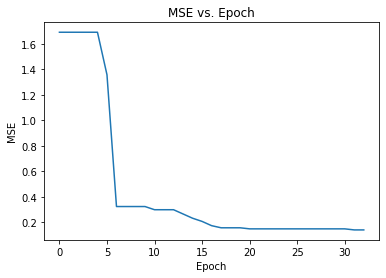

In [7]:
# get list of MSE perEpoch = SSE/n -> SSE = (t - z)**2
def plot_mse(avg_mse_rate):
    plt.plot(np.arange(len(avg_mse_rate)), avg_mse_rate)
    plt.title("MSE vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.show
plot_mse(irisMLP.MSEperEpoch)

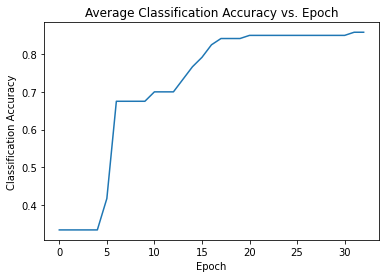

In [8]:
# get list of calculation accuracy perEpoch
def plot_classification(avg_classification_rate):
    """
        Plots the average misclassification rate
    Args:
        avg_misclassification_rate (array-like): A 1D array or list
    """
    plt.plot(np.arange(len(avg_classification_rate)), avg_classification_rate)
    plt.title("Average Classification Accuracy vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Classification Accuracy")
    plt.show()
plot_classification(irisMLP.classificationAcc_perEpoch)

In [9]:
# print test accuracy
headers = ["Trial", "Test Accuracy", "Number of Epochs"]
table = []
table.append([1, irisMLP.score(X_test, y_test, False), irisMLP.ranEpochs])
display(HTML(tabulate(table, headers = headers, tablefmt='html')))

Trial,Test Accuracy,Number of Epochs
1,0.858333,33


## 3. (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset [Vowel Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 80/20 splits of the data for the training/test set.
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Try some different learning rates (LR). Note that each LR will probably require a different number of epochs to learn. 

- For each LR you test, plot their validation's set MSE over Epochs on the same graph. Graph 4-5 different LRs and make them different enough to see a difference between them.

In general, whenever you are testing a parameter such as LR, # of hidden nodes, etc., test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

If you would like you may average the results of multiple initial conditions (e.g. 3) per LR, and that obviously would give more accurate results.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

In [10]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff --output vowel_data.arff
vowel_data = arff.loadarff('vowel_data.arff')
vowel_df = pd.DataFrame(vowel_data[0])
vowel_df = vowel_df.drop(columns=['Train or Test', 'Speaker Number', 'Sex'])
train = vowel_df.sample(frac=0.8,random_state=0)
test = vowel_df.drop(train.index)

#for feature_name in train.columns:
#    if feature_name == 'Class':
#        break
#    max_value = train[feature_name].max()
#    min_value = train[feature_name].min()
#    train[feature_name] = (train[feature_name] - min_value) / (max_value - min_value)

custom_mapping_vowel1 = {'Male':1, 'Female':0}
custom_mapping_vowel2 = {'hid':0, 'hEd':1, 'hud':2, 'hUd':3, 'hOd':4, 'had':5, 'hAd':6, 'hId':7, 'hod':8, 'hed':9, 'hYd':10}

print(train.head())
#train['Sex'] = train['Sex'].str.decode("utf-8")
#train['Sex'] = train['Sex'].map(custom_mapping_vowel1)
#test['Sex'] = test['Sex'].str.decode("utf-8")
#test['Sex'] = test['Sex'].map(custom_mapping_vowel1)

train['Class'] = train['Class'].str.decode("utf-8")
train['Class'] = train['Class'].map(custom_mapping_vowel2)
test['Class'] = test['Class'].str.decode("utf-8")
test['Class'] = test['Class'].map(custom_mapping_vowel2)

train_np_data = train.to_numpy()
test_np_data = train.to_numpy()

train_np_data = train_np_data.astype(float)
test_np_data = test_np_data.astype(float)

train_np_data = train_np_data.tolist()
test_np_data = test_np_data.tolist()


X_train_vowel = []
y_train_vowel = []

for item in train_np_data:
    X_train_vowel.append(item[0:len(item)-1])
    y_train_vowel.append(item[len(item)-1])

X_test_vowel = []
y_test_vowel = []

for item in test_np_data:
    X_test_vowel.append(item[0:len(item)-1])
    y_test_vowel.append(item[len(item)-1])

# --------------------- 0 ----------------------
vowelMLP0 = MLP(lr=0.05, momentum=0.5, validationSize=15,shuffle=False, numEpochs=100, sensitivity=18) # use validation set as stopping criteria

# Train on evaluation data
vowelMLP0.set_numOutput(11)
vowelMLP0.fit(X_train_vowel, y_train_vowel)
print(vowelMLP0.ranEpochs)

# --------------------- 1 ----------------------
# Train on each dataset
vowelMLP1 = MLP(lr=0.1, momentum=0.5, validationSize=15,shuffle=False, numEpochs=700, sensitivity=18) # use validation set as stopping criteria

# Train on evaluation data
vowelMLP1.set_numOutput(11)
vowelMLP1.fit(X_train_vowel, y_train_vowel)
print(vowelMLP1.ranEpochs)

# --------------------- 2 ----------------------
vowelMLP2 = MLP(lr=0.12, momentum=0.5, validationSize=15,shuffle=False, numEpochs=100, sensitivity=18) # use validation set as stopping criteria

# Train on evaluation data
vowelMLP2.set_numOutput(11)
vowelMLP2.fit(X_train_vowel, y_train_vowel)
print(vowelMLP2.ranEpochs)

# --------------------- 3 ----------------------
vowelMLP3 = MLP(lr=0.3, momentum=0.5, validationSize=15,shuffle=False, numEpochs=100, sensitivity=18) # use validation set as stopping criteria

# Train on evaluation data
vowelMLP3.set_numOutput(11)
vowelMLP3.fit(X_train_vowel, y_train_vowel)
print(vowelMLP3.ranEpochs)

# --------------------- 4 ----------------------
vowelMLP4 = MLP(lr=0.4, momentum=0.5, validationSize=15,shuffle=False, numEpochs=100, sensitivity=18) # use validation set as stopping criteria

# Train on evaluation data
vowelMLP4.set_numOutput(11)
vowelMLP4.fit(X_train_vowel, y_train_vowel)
print(vowelMLP4.ranEpochs)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91402  100 91402    0     0   264k      0 --:--:-- --:--:-- --:--:--  264k
     Feature 0  Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  \
747     -3.265      1.933     -0.316      0.602      0.438      0.336   
625     -4.753      3.421     -0.189      0.656     -0.984      1.443   
298     -3.049      0.084      0.981      1.193      0.761      0.495   
746     -4.028      0.982     -0.648      1.478     -0.048      2.108   
45      -3.046      0.387     -1.165      0.940     -0.386      1.978   

     Feature 6  Feature 7  Feature 8  Feature 9   Class  
747      0.048      0.134     -0.160     -0.991  b'hed'  
625     -0.652      0.546      0.123     -0.326  b'hud'  
298     -0.714     -0.466     -0.568     -0.149  b'hId'  
746     -0.146      0.467     -0.654     -0.193  b'hud'  
45      -0.186      0.811     -0.3

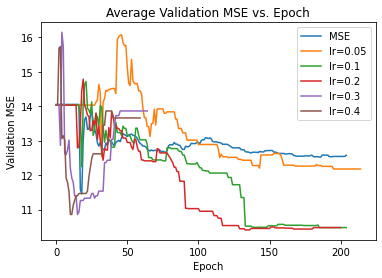

In [11]:
# get list of calculation accuracy perEpoch
def plot_valMSE(test123, avg_valmse_rate0, avg_valmse_rate1, avg_valmse_rate2, avg_valmse_rate3, avg_valmse_rate4):
    """
        Plots the average misclassification rate
    Args:
        avg_misclassification_rate (array-like): A 1D array or list
    """
    plt.plot(np.arange(len(test123)), test123, label='MSE')
    plt.plot(np.arange(len(avg_valmse_rate0)), avg_valmse_rate0, label='lr=0.05')
    plt.plot(np.arange(len(avg_valmse_rate1)), avg_valmse_rate1, label='lr=0.1')
    plt.plot(np.arange(len(avg_valmse_rate2)), avg_valmse_rate2, label='lr=0.2')
    plt.plot(np.arange(len(avg_valmse_rate3)), avg_valmse_rate3, label='lr=0.3')
    plt.plot(np.arange(len(avg_valmse_rate4)), avg_valmse_rate4, label='lr=0.4')
    plt.title("Average Validation MSE vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Validation MSE")
    plt.legend()
    plt.show()
plot_valMSE(vowelMLP1.MSEperEpoch, vowelMLP0.MSEperEpoch_validation, vowelMLP1.MSEperEpoch_validation, vowelMLP2.MSEperEpoch_validation, vowelMLP3.MSEperEpoch_validation, vowelMLP4.MSEperEpoch_validation)




## 3.1 (5%) Working with the Vowel Dataset - Intuition
- Discuss the effect of varying learning rates. 
- Discuss why the vowel data set might be more difficult than Iris
    - Report both datasets' baseline accuracies and best **test** set accuracies. 
- Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, ect) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.



*Discuss Intuition here*<br>
Something interesting that I noticed, was that each learning rate found a local minimum fairly quickly. Then most of them began to traverse out of it because of the validation criteria. I noticed that 0.2 or 0.4 achieved the absolute lowest validation MSE which is interesting because they were both even learning rates. However, it seemed to me that a learning rate of 0.1 learned the best, because after reaching a minimum, it climbed like the rest, but began to decend again, which to me meant that it continued to learn. I would say this data set is more difficult than the iris dataset because there are so many more classification classes. This required us to have 11 output classes which meant more hidden layers. 



In [12]:
headers = ["Trial", "Learning Rate", "Training Accuracy", "Testing Accuracy", "Number of Epochs"]
table = []
table.append([0, vowelMLP0.lr, vowelMLP0.score(X_train_vowel, y_train_vowel, False), vowelMLP0.score(X_test_vowel, y_test_vowel, False), vowelMLP0.ranEpochs])
table.append([1, vowelMLP1.lr, vowelMLP1.score(X_train_vowel, y_train_vowel, False), vowelMLP1.score(X_test_vowel, y_test_vowel, False), vowelMLP1.ranEpochs])
table.append([2, vowelMLP2.lr, vowelMLP2.score(X_train_vowel, y_train_vowel, False), vowelMLP2.score(X_test_vowel, y_test_vowel, False), vowelMLP2.ranEpochs])
table.append([3, vowelMLP3.lr, vowelMLP3.score(X_train_vowel, y_train_vowel, False), vowelMLP3.score(X_test_vowel, y_test_vowel, False), vowelMLP3.ranEpochs])
table.append([4, vowelMLP4.lr, vowelMLP4.score(X_train_vowel, y_train_vowel, False), vowelMLP4.score(X_test_vowel, y_test_vowel, False), vowelMLP4.ranEpochs])

display(HTML(tabulate(table, headers = headers, tablefmt='html')))

Trial,Learning Rate,Training Accuracy,Testing Accuracy,Number of Epochs
0,0.05,0.315657,0.315657,215
1,0.1,0.335859,0.335859,205
2,0.12,0.338384,0.338384,201
3,0.3,0.286616,0.286616,65
4,0.4,0.282828,0.282828,60


## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

In [13]:
# --------------------- 0 ----------------------
vowelMLP0 = MLP(lr=0.12, momentum=0.5, validationSize=15,shuffle=False, numEpochs=100, sensitivity=18, hidden_layer_widths=4) # use validation set as stopping criteria

# Train on evaluation data
vowelMLP0.set_numOutput(11)
vowelMLP0.fit(X_train_vowel, y_train_vowel)
print(vowelMLP0.ranEpochs)

# --------------------- 1 ----------------------
# Train on each dataset
vowelMLP1 = MLP(lr=0.12, momentum=0.5, validationSize=15,shuffle=False, numEpochs=700, sensitivity=18, hidden_layer_widths=16) # use validation set as stopping criteria

# Train on evaluation data
vowelMLP1.set_numOutput(11)
vowelMLP1.fit(X_train_vowel, y_train_vowel)
print(vowelMLP1.ranEpochs)

# --------------------- 2 ----------------------
vowelMLP2 = MLP(lr=0.12, momentum=0.5, validationSize=15,shuffle=False, numEpochs=100, sensitivity=18, hidden_layer_widths=32) # use validation set as stopping criteria

# Train on evaluation data
vowelMLP2.set_numOutput(11)
vowelMLP2.fit(X_train_vowel, y_train_vowel)
print(vowelMLP2.ranEpochs)

# --------------------- 3 ----------------------
vowelMLP3 = MLP(lr=0.12, momentum=0.5, validationSize=15,shuffle=False, numEpochs=100, sensitivity=18, hidden_layer_widths=64) # use validation set as stopping criteria

# Train on evaluation data
vowelMLP3.set_numOutput(11)
vowelMLP3.fit(X_train_vowel, y_train_vowel)
print(vowelMLP3.ranEpochs)

# --------------------- 4 ----------------------
vowelMLP4 = MLP(lr=0.12, momentum=0.5, validationSize=15,shuffle=False, numEpochs=100, sensitivity=18, hidden_layer_widths=128) # use validation set as stopping criteria

# Train on evaluation data
vowelMLP4.set_numOutput(11)
vowelMLP4.fit(X_train_vowel, y_train_vowel)
print(vowelMLP4.ranEpochs)

lw:  4
103
lw:  16
176
lw:  32
124
lw:  64
56
lw:  128
119


In [14]:
headers = ["Trial", "Hidden Layer Width", "Training Accuracy", "Testing Accuracy", "Number of Epochs"]
table = []
table.append([0, vowelMLP0.hidden_layer_widths, vowelMLP0.score(X_train_vowel, y_train_vowel, False), vowelMLP0.score(X_test_vowel, y_test_vowel, False), vowelMLP0.ranEpochs])
table.append([1, vowelMLP1.hidden_layer_widths, vowelMLP1.score(X_train_vowel, y_train_vowel, False), vowelMLP1.score(X_test_vowel, y_test_vowel, False), vowelMLP1.ranEpochs])
table.append([2, vowelMLP2.hidden_layer_widths, vowelMLP2.score(X_train_vowel, y_train_vowel, False), vowelMLP2.score(X_test_vowel, y_test_vowel, False), vowelMLP2.ranEpochs])
table.append([3, vowelMLP3.hidden_layer_widths, vowelMLP3.score(X_train_vowel, y_train_vowel, False), vowelMLP3.score(X_test_vowel, y_test_vowel, False), vowelMLP3.ranEpochs])
table.append([4, vowelMLP4.hidden_layer_widths, vowelMLP4.score(X_train_vowel, y_train_vowel, False), vowelMLP4.score(X_test_vowel, y_test_vowel, False), vowelMLP4.ranEpochs])

display(HTML(tabulate(table, headers = headers, tablefmt='html')))

Trial,Hidden Layer Width,Training Accuracy,Testing Accuracy,Number of Epochs
0,4,0.329545,0.329545,103
1,16,0.338384,0.338384,176
2,32,0.294192,0.294192,124
3,64,0.291667,0.291667,56
4,128,0.289141,0.289141,119


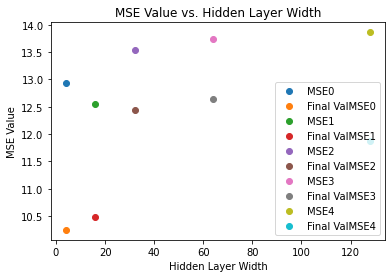

In [15]:
# get list of calculation accuracy perEpoch
def plot_valMSE2(avg_mse_rate0, avg_valmse_rate0, avg_mse_rate1, avg_valmse_rate1, avg_mse_rate2, avg_valmse_rate2, avg_mse_rate3, avg_valmse_rate3, avg_mse_rate4, avg_valmse_rate4):
    """
        Plots the average misclassification rate
    Args:
        avg_misclassification_rate (array-like): A 1D array or list
    """
    plt.scatter(vowelMLP0.hidden_layer_widths, avg_mse_rate0[len(avg_mse_rate0)-1], label='MSE0')
    plt.scatter(vowelMLP0.hidden_layer_widths, avg_valmse_rate0[len(avg_valmse_rate0)-1], label='Final ValMSE0')

    plt.scatter(vowelMLP1.hidden_layer_widths, avg_mse_rate1[len(avg_mse_rate1)-1], label='MSE1')
    plt.scatter(vowelMLP1.hidden_layer_widths, avg_valmse_rate1[len(avg_valmse_rate1)-1], label='Final ValMSE1')

    plt.scatter(vowelMLP2.hidden_layer_widths, avg_mse_rate2[len(avg_mse_rate2)-1], label='MSE2')
    plt.scatter(vowelMLP2.hidden_layer_widths, avg_valmse_rate2[len(avg_valmse_rate2)-1], label='Final ValMSE2')

    plt.scatter(vowelMLP3.hidden_layer_widths, avg_mse_rate3[len(avg_mse_rate3)-1], label='MSE3')
    plt.scatter(vowelMLP3.hidden_layer_widths, avg_valmse_rate3[len(avg_valmse_rate3)-1], label='Final ValMSE3')

    plt.scatter(vowelMLP4.hidden_layer_widths, avg_mse_rate4[len(avg_mse_rate4)-1], label='MSE4')
    plt.scatter(vowelMLP4.hidden_layer_widths, avg_valmse_rate4[len(avg_valmse_rate4)-1], label='Final ValMSE4')
  
    plt.title("MSE Value vs. Hidden Layer Width")
    plt.xlabel("Hidden Layer Width")
    plt.ylabel("MSE Value")
    plt.legend()
    plt.show()
plot_valMSE2(vowelMLP0.MSEperEpoch, vowelMLP0.MSEperEpoch_validation, vowelMLP1.MSEperEpoch, vowelMLP1.MSEperEpoch_validation, vowelMLP2.MSEperEpoch, vowelMLP2.MSEperEpoch_validation, vowelMLP3.MSEperEpoch, vowelMLP3.MSEperEpoch_validation, vowelMLP4.MSEperEpoch, vowelMLP4.MSEperEpoch_validation)



In [16]:
headers = ["Trial", "Number of Hidden Layer Nodes", "Testing Accuracy", "Number of Epochs"]
table = []
table.append([0, vowelMLP0.hidden_layer_widths, vowelMLP0.score(X_test_vowel, y_test_vowel, False), vowelMLP0.ranEpochs])
table.append([1, vowelMLP1.hidden_layer_widths, vowelMLP1.score(X_test_vowel, y_test_vowel, False), vowelMLP1.ranEpochs])
table.append([2, vowelMLP2.hidden_layer_widths, vowelMLP2.score(X_test_vowel, y_test_vowel, False), vowelMLP2.ranEpochs])
table.append([3, vowelMLP3.hidden_layer_widths, vowelMLP3.score(X_test_vowel, y_test_vowel, False), vowelMLP3.ranEpochs])
table.append([4, vowelMLP4.hidden_layer_widths, vowelMLP4.score(X_test_vowel, y_test_vowel, False), vowelMLP4.ranEpochs])

display(HTML(tabulate(table, headers = headers, tablefmt='html')))

Trial,Number of Hidden Layer Nodes,Testing Accuracy,Number of Epochs
0,4,0.329545,103
1,16,0.338384,176
2,32,0.294192,124
3,64,0.291667,56
4,128,0.289141,119


*Discuss Hidden Layer Nodes here*<br>
For the best number of Hidden Layers, I foudn that for the best MSE/ValMSE combination, that 4 Hidden layer nodes were the best. However when it came to testing accuracy, 16 was slightly better. I would say that 16 performed more accuractly because it ran for more epochs. However I would argue that it potentially began to overfit the data more than 4 hidden layers. This makes sense to me, because if the number of Hidden layer nodes greatly surpasses the number of outputs, that decreases the amount of information that each node represents, potentially leading to over abstraction / feature loss because they can't be split into small enough sizes. Also probably due to the lack of data size.



## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms using the best number of hidden nodes and LR from your earlier experiments.

- Create a graph similar to step 3.2, but with momentum on the x-axis and number of epochs until validation set convergence on the y-axis.
- For each momentum term, print the test set accuracy. 
- You are trying to see how much momentum speeds up learning and how it affects accuracy.

In [17]:
# --------------------- 0 ----------------------
vowelMLP0 = MLP(lr=0.12, momentum=0.5, validationSize=15,shuffle=False, numEpochs=100, sensitivity=18, hidden_layer_widths=16) # use validation set as stopping criteria

# Train on evaluation data
vowelMLP0.set_numOutput(11)
vowelMLP0.fit(X_train_vowel, y_train_vowel)
print(vowelMLP0.ranEpochs)

# --------------------- 1 ----------------------
# Train on each dataset
vowelMLP1 = MLP(lr=0.12, momentum=0.6, validationSize=15,shuffle=False, numEpochs=700, sensitivity=18, hidden_layer_widths=16) # use validation set as stopping criteria

# Train on evaluation data
vowelMLP1.set_numOutput(11)
vowelMLP1.fit(X_train_vowel, y_train_vowel)
print(vowelMLP1.ranEpochs)

# --------------------- 2 ----------------------
vowelMLP2 = MLP(lr=0.12, momentum=0.7, validationSize=15,shuffle=False, numEpochs=100, sensitivity=18, hidden_layer_widths=16) # use validation set as stopping criteria

# Train on evaluation data
vowelMLP2.set_numOutput(11)
vowelMLP2.fit(X_train_vowel, y_train_vowel)
print(vowelMLP2.ranEpochs)

# --------------------- 3 ----------------------
vowelMLP3 = MLP(lr=0.12, momentum=0.8, validationSize=15,shuffle=False, numEpochs=100, sensitivity=18, hidden_layer_widths=16) # use validation set as stopping criteria

# Train on evaluation data
vowelMLP3.set_numOutput(11)
vowelMLP3.fit(X_train_vowel, y_train_vowel)
print(vowelMLP3.ranEpochs)

# --------------------- 4 ----------------------
vowelMLP4 = MLP(lr=0.12, momentum=0.85, validationSize=15,shuffle=False, numEpochs=100, sensitivity=18, hidden_layer_widths=16) # use validation set as stopping criteria

# Train on evaluation data
vowelMLP4.set_numOutput(11)
vowelMLP4.fit(X_train_vowel, y_train_vowel)
print(vowelMLP4.ranEpochs)

lw:  16
176
lw:  16
163
lw:  16
307
lw:  16
49
lw:  16
134


In [18]:
headers = ["Trial", "Momentum", "Training Accuracy", "Testing Accuracy", "Number of Epochs"]
table = []
table.append([0, vowelMLP0.momentum, vowelMLP0.score(X_train_vowel, y_train_vowel, False), vowelMLP0.score(X_test_vowel, y_test_vowel, False), vowelMLP0.ranEpochs])
table.append([1, vowelMLP1.momentum, vowelMLP1.score(X_train_vowel, y_train_vowel, False), vowelMLP1.score(X_test_vowel, y_test_vowel, False), vowelMLP1.ranEpochs])
table.append([2, vowelMLP2.momentum, vowelMLP2.score(X_train_vowel, y_train_vowel, False), vowelMLP2.score(X_test_vowel, y_test_vowel, False), vowelMLP2.ranEpochs])
table.append([3, vowelMLP3.momentum, vowelMLP3.score(X_train_vowel, y_train_vowel, False), vowelMLP3.score(X_test_vowel, y_test_vowel, False), vowelMLP3.ranEpochs])
table.append([4, vowelMLP4.momentum, vowelMLP4.score(X_train_vowel, y_train_vowel, False), vowelMLP4.score(X_test_vowel, y_test_vowel, False), vowelMLP4.ranEpochs])

display(HTML(tabulate(table, headers = headers, tablefmt='html')))

Trial,Momentum,Training Accuracy,Testing Accuracy,Number of Epochs
0,0.5,0.338384,0.338384,176
1,0.6,0.340909,0.340909,163
2,0.7,0.263889,0.263889,307
3,0.8,0.277778,0.277778,49
4,0.85,0.265152,0.265152,134


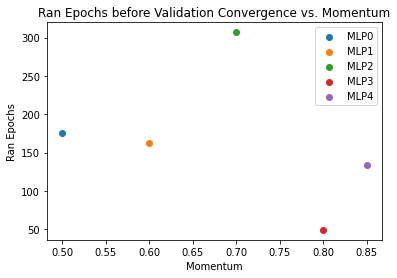

In [19]:
def plot_valMSE3():
    """
        Plots the average misclassification rate
    Args:
        avg_misclassification_rate (array-like): A 1D array or list
    """
    plt.scatter(vowelMLP0.momentum, vowelMLP0.ranEpochs, label='MLP0')

    plt.scatter(vowelMLP1.momentum, vowelMLP1.ranEpochs, label='MLP1')

    plt.scatter(vowelMLP2.momentum, vowelMLP2.ranEpochs, label='MLP2')

    plt.scatter(vowelMLP3.momentum, vowelMLP3.ranEpochs, label='MLP3')

    plt.scatter(vowelMLP4.momentum, vowelMLP4.ranEpochs, label='MLP4')
  
    plt.title("Ran Epochs before Validation Convergence vs. Momentum")
    plt.xlabel("Momentum")
    plt.ylabel("Ran Epochs")
    plt.legend()
    plt.show()
plot_valMSE3()

*Discuss Momentum here*<br>
It seems to me that the higher than momentum is, the less epochs get run before convergence. I think that this could be due to the fact that minimums could be skipped over because the momentum causes it to skip past them. There was obviously a case where the momentum was just right to get the model to continue training, but that is the importance of hyper-parameter searching. This would also have a correlation to accuracy, because the model might not be able to find those minimum's to optimize. So the model won't be as accurate as it could be.



## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [65]:
# Load sklearn perceptron

clf = MLPClassifier(hidden_layer_sizes=101, learning_rate_init=0.05, shuffle=True, momentum=0.1, early_stopping=True, validation_fraction=0.15).fit(X_train_vowel, y_train_vowel)
print(clf.score(X_test_vowel, y_test_vowel))

clf2 = MLPClassifier(hidden_layer_sizes=76, learning_rate_init=0.1, shuffle=True, momentum=0.2, early_stopping=True, validation_fraction=0.15).fit(X_train, y_train)
print(clf2.score(X_test, y_test))

0.9936868686868687
0.9833333333333333


*Record impressions* <br>
It seemed to me that to a certain point, adding in extra hidden layers would increase accuracy, but it would eventually end up converging and adding more layers would not improve performance very much. I also noticed the same behavior when decreasing learning rate. However, sometimes decreasing learning rate too much would cause worse performance. This was the same with momentum. The lower the value, the more accurate it seemed to perform.

## 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [82]:
# Load sklearn perceptron
clf11 = MLPClassifier(hidden_layer_sizes=45, learning_rate_init=0.05, shuffle=True, momentum=0.1, early_stopping=True, validation_fraction=0.15).fit(X_train, y_train)
print(clf11.score(X_test, y_test))

clf22 = MLPClassifier(hidden_layer_sizes=45, learning_rate_init=0.1, shuffle=True, momentum=0.1, early_stopping=True, validation_fraction=0.15).fit(X_train, y_train)
print(clf22.score(X_test, y_test))

clf33 = MLPClassifier(hidden_layer_sizes=45, learning_rate_init=0.15, shuffle=True, momentum=0.1, early_stopping=True, validation_fraction=0.15).fit(X_train, y_train)
print(clf33.score(X_test, y_test))

clf44 = MLPClassifier(hidden_layer_sizes=45, learning_rate_init=0.2, shuffle=True, momentum=0.1, early_stopping=True, validation_fraction=0.15).fit(X_train, y_train)
print(clf44.score(X_test, y_test))

clf55 = MLPClassifier(hidden_layer_sizes=45, learning_rate_init=0.25, shuffle=True, momentum=0.1, early_stopping=True, validation_fraction=0.15).fit(X_train, y_train)
print(clf55.score(X_test, y_test))


0.9833333333333333
0.9916666666666667
0.925
0.975
0.9666666666666667


It seemed to me, after checking hidden layer size, finding the best one, learning rate, and finding the best one, as well as doing the same process with moment, that hidden layer size=45 learning rate=0.1 and momentum=0.1 were some of the best hyper parameters to use. I used a grid style search, but comparing increments of each model to itself and finding which has the best accuracy

## 5. (Optional 5% Extra credit) For the vowel data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, and momentum.  

- Compare and discuss the values found with the ones you found in part 3.


In [178]:
clf111 = MLPClassifier(hidden_layer_sizes=500, learning_rate_init=0.005, shuffle=True, momentum=0.2, early_stopping=True, validation_fraction=0.10).fit(X_train_vowel, y_train_vowel)
print(clf111.score(X_test_vowel, y_test_vowel))

0.9936868686868687


*Discuss findings here* <br>
I did a random search for this one. I randomly changed the values around until I was able to get the highest possible accuracy. This was accuracy was 99.4. It seemed that the more fine tuning I did to the validation set size helped with the consistency of accuracy scored more than I had assumed that it would have!